Figures shown in this notebook are static. To try dynamic interactive charts run fig.show() commands without "png" argument in Jupyter.

## Imports

In [1]:
pip install -U plotly

     |████████████████████████████████| 20.6MB 140kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
pip install kaleido

     |████████████████████████████████| 79.9MB 36kB/s 


In [3]:
import json
import pandas as pd
import numpy as np
import plotly.express as px
import requests

In [6]:
path='' #
path='drive/MyDrive/geojson polska/fetch data/visualization/'

## Loading geojson map files

In [7]:
with open(path+'Województwa07.json') as response:
    woj_geo_07 = json.load(response)
with open(path+'Regiony1.json') as response:
    regiony = json.load(response)
with open(path+'Powiaty.json') as response:
    powiaty = json.load(response)

## Handling duplicate names in lvl 5 (powiaty)

In [8]:
nazwy_powiatow=[x['properties']['JPT_NAZWA_'] for x in powiaty['features']]

from collections import Counter

names=dict(Counter(nazwy_powiatow))

for key, count in names.items():
    if count>1:
        print(key)

powiat grodziski
powiat tomaszowski
powiat brzeski
powiat krośnieński
powiat średzki
powiat bielski
powiat opolski
powiat ostrowski
powiat nowodworski
powiat świdnicki


In [9]:
podwojne=[key for key,count in names.items() if count>1]

In [10]:
# kody województw posłużą do rozróżnienia powtarzających się nazw powiatów
kody= {
'12'  :  'małopolskie' ,
'24': 'śląskie' ,
'08' :'lubuskie' ,
'30' :'wielkopolskie' ,
'32' :'zachodniopomorskie' ,
'02': 'dolnośląskie' ,
'16': 'opolskie' ,
'04': 'kujawsko-pomorskie' ,
'22': 'pomorskie' ,
'28' :'warmińsko-mazurskie' ,
'10': 'łódzkie' ,
'26': 'świętokrzyskie' ,
'06' :'lubelskie' ,
'18' :'podkarpackie' ,
'20' :'podlaskie' ,
'14' :'mazowieckie' 

}

In [11]:
kod='042200000000'[2:4] # 3. i 4. cyfra to kod województwa
kody[kod]

'pomorskie'

In [12]:
powiaty_fix = powiaty.copy()

In [13]:
for id, item in enumerate(powiaty['features']):
    nazwa=item['properties']['JPT_NAZWA_']
    if nazwa in podwojne:
        kod=item['properties']['JPT_KOD_JE'][:2]
        nazwa=nazwa+", "+kody[kod]
        powiaty_fix['features'][id]['properties']['JPT_NAZWA_']=nazwa

In [ ]:
with open(path+"powiaty_fix.json", "w") as outfile:  
    json.dump(powiaty_fix, outfile, ensure_ascii=False) 

## Download data

### function

In [14]:


def load_data2(first_year,last_year,unit_level=2,variable=6454):
    
    page_size=100 
    first_url='https://bdl.stat.gov.pl/api/v1/data/by-variable/'+str(variable)+'?unit-level='+str(unit_level)+'&page=0&page-size='+str(page_size)

    for year in range(first_year,last_year+1):
        first_url+='&year='+str(year)

    first_page = requests.get(first_url, timeout=7)
    first_page = first_page.json()

    last_page_num=0 

    if first_page['totalRecords']>100:
        last_url=first_page['links']['last'] 
        last_page_num=last_url[last_url.find("page=")+5:last_url.find("&page-size")] 
        

    list_of_tuples=[] # list -> [(unit, year, value)] 

    urls1=[]
    for page_num in range(int(last_page_num)+1):
        urls1.append(first_url.replace("page=0","page="+str(page_num)))

    for url in urls1: 
        if url==first_url: 
            payload=first_page
        else:
            response = requests.get(url, timeout=7)
            payload=response.json() 

        # changing names so they match names in geojson map files

        if unit_level==2:
            list_of_tuples.extend(
                (wojewodztwo['name'].lower(), wartosci['year'], wartosci['val']) 
                for wojewodztwo in payload['results']
                for wartosci in wojewodztwo['values'] 
                )
        
        elif unit_level==3:
            list_of_tuples.extend([(region['name'].replace("REGION ","").lower(), wartosci['year'], wartosci['val'])
             for region in payload['results'] for wartosci in region['values']])      
            


        elif unit_level==5: 
            for powiat in payload['results']:
                name=powiat['name']
                name=name[0].lower() + name[1:] # Powiat krakowski -> powiat krakowski
                name=name.replace("m.","") # powiat m. Kraków -> powiat Kraków
                name=name.replace("karkonoski","jeleniogórski") # ...
                name=name.replace("powiat  st. Warszawa", "powiat Warszawa")
                if name in podwojne: 
                    kod=powiat['id'][2:4]
                    name=name+", "+kody[kod] # powiat grodziski -> powiat grodziski, mazowieckie
                for x in powiat['values']:
                    list_of_tuples.append((name,x['year'],x['val']))
        else: # other levels
            list_of_tuples.extend(
                (x['name'], wartosci['year'], wartosci['val']) 
                for x in payload['results']
                for wartosci in x['values'] 
                )

    
    return list_of_tuples
    # or return df

### downloading and saving

In [ ]:
# wydatki budżetów województw per capita
wyd_woj_pc = load_data2(2011,2020,2,60518)
wydatki_wojewodztw_pc=pd.DataFrame(wyd_woj_pc, columns=["województwo","rok","wartość"])
wydatki_wojewodztw_pc.to_csv(path+"wydatki_budżetów_województw_per_capita.csv", index=False)

In [ ]:
# dochody gmin per capita, zagregowane do poziomu regionów NUTS-2
dochody_gmin_pc_regiony = load_data2(2011,2021,3,76975)
df_dochody_gmin_pc_regiony=pd.DataFrame(dochody_gmin_pc_regiony, columns=["region","rok","wartość"])
df_dochody_gmin_pc_regiony.to_csv(path+"dochody_gmin_pc_regiony.csv", index=False)

In [ ]:
# dochody ogółem gmin i miast powiatów, poziom powiaty
dochody_ogolem_gmin_powiaty = load_data2(2011,2021,5,76037)
dochody_ogolem_gmin_powiaty = pd.DataFrame(dochody_ogolem_gmin_powiaty, columns=["powiat","rok","wartość"])
dochody_ogolem_gmin_powiaty.to_csv(path+"dochody_ogolem_gmin_powiaty.csv", index=False)


In [ ]:
# dochody powiatów na 1 mieszkańca
dochody_powiatow_pc = load_data2(2011,2021,5,60505)
dochody_powiatow_pc=pd.DataFrame(dochody_powiatow_pc, columns=["powiat","rok","wartość"])
dochody_powiatow_pc.to_csv(path+"dochody_powiatow_pc.csv", index=False)

## Or load saved data


In [15]:
wydatki_wojewodztw_pc = pd.read_csv(path+'wydatki_budżetów_województw_per_capita.csv')
df_dochody_gmin_pc_regiony = pd.read_csv(path+"dochody_gmin_pc_regiony.csv")
dochody_ogolem_gmin_powiaty = pd.read_csv(path+"dochody_ogolem_gmin_powiaty.csv")
dochody_powiatow_pc = pd.read_csv(path+"dochody_powiatow_pc.csv")

## Maps

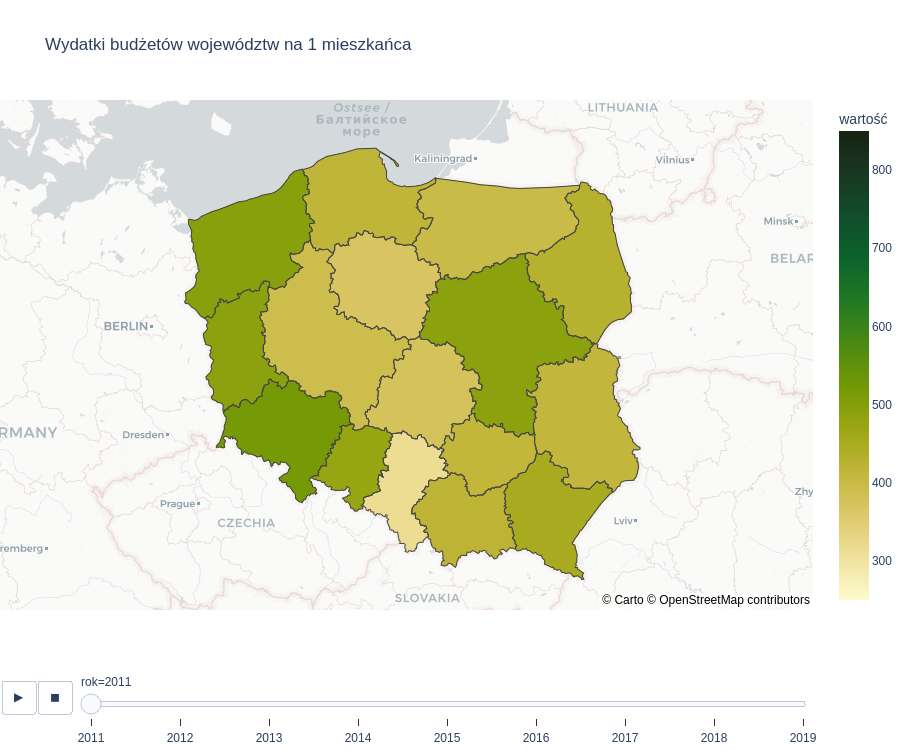

In [16]:
fig = px.choropleth_mapbox(wydatki_wojewodztw_pc, geojson=woj_geo_07, locations='województwo',
                           featureidkey="properties.JPT_NAZWA_", color='wartość',
                           animation_frame="rok", color_continuous_scale="speed",
                           range_color=[250,850],
                           center={"lat": 52.1331, "lon": 19},
                           mapbox_style="carto-positron",
                           zoom=5,
                           opacity=1,
                           title="Wydatki budżetów województw na 1 mieszkańca"
                          )
fig.update_layout(width=900,height=750,margin={"r":0,"t":100,"l":0,"b":0})
#fig.show()
fig.show("png")

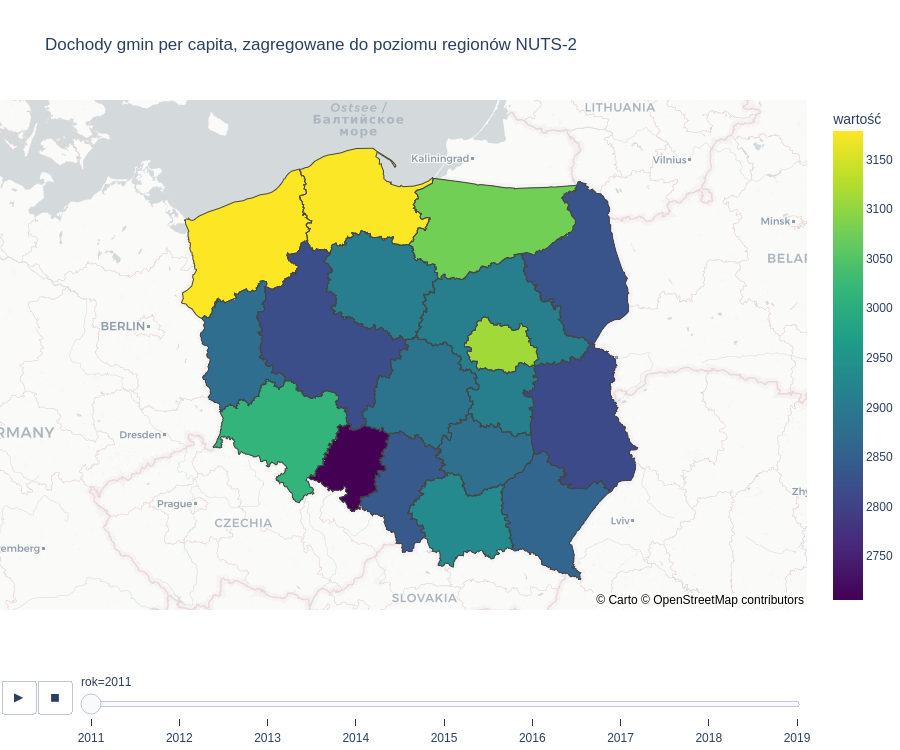

In [17]:
fig = px.choropleth_mapbox(df_dochody_gmin_pc_regiony, geojson=regiony, locations='region',
                           featureidkey="properties.JPT_NAZWA_", color='wartość',animation_frame="rok",
                           color_continuous_scale="Viridis",
                           center={"lat": 52.1331, "lon": 19},
                           mapbox_style="carto-positron",
                           zoom=5,
                           opacity=1,
                           title="Dochody gmin per capita, zagregowane do poziomu regionów NUTS-2"
                          )
fig.update_layout(width=900,height=750, margin={"r":0,"t":100,"l":0,"b":0})
#fig.show()
fig.show("png")

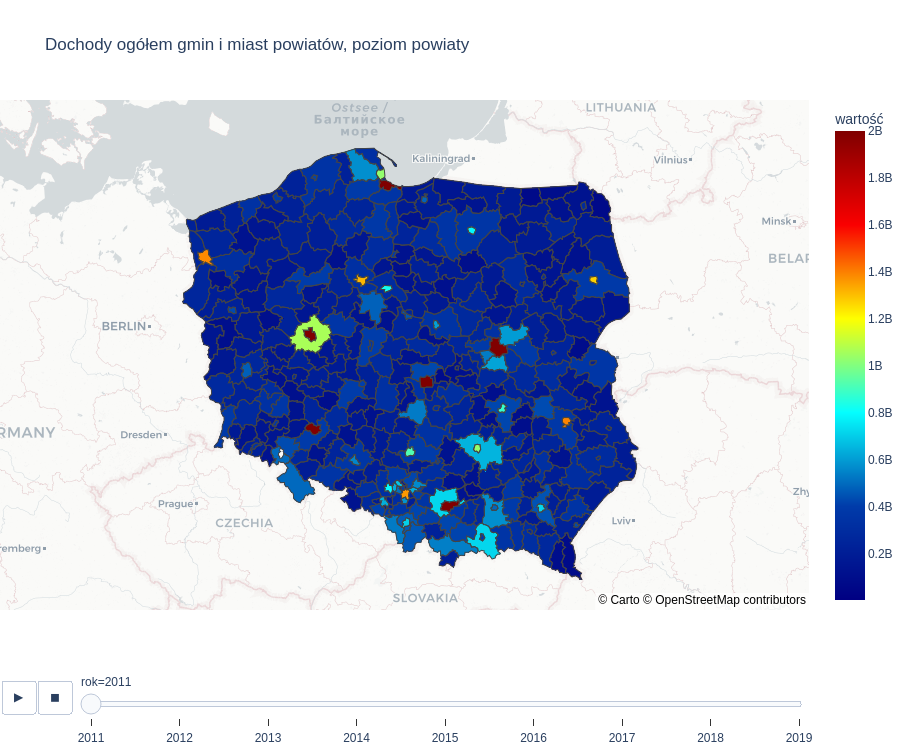

CPU times: user 4.16 s, sys: 41.2 ms, total: 4.2 s
Wall time: 8.41 s


In [18]:
%%time
fig = px.choropleth_mapbox(dochody_ogolem_gmin_powiaty, geojson=powiaty_fix, locations='powiat',
                           featureidkey="properties.JPT_NAZWA_", color='wartość',
                           animation_frame="rok", color_continuous_scale="jet",
                           range_color=[1*10**6,2*10**9],
                           center={"lat": 52.1331, "lon": 19},
                           mapbox_style="carto-positron",
                           zoom=5,
                           opacity=1,
                           title="Dochody ogółem gmin i miast powiatów, poziom powiaty"
                          )
fig.update_layout(width=900,height=750,margin={"r":0,"t":100,"l":0,"b":0})
#fig.show()
fig.show("png")

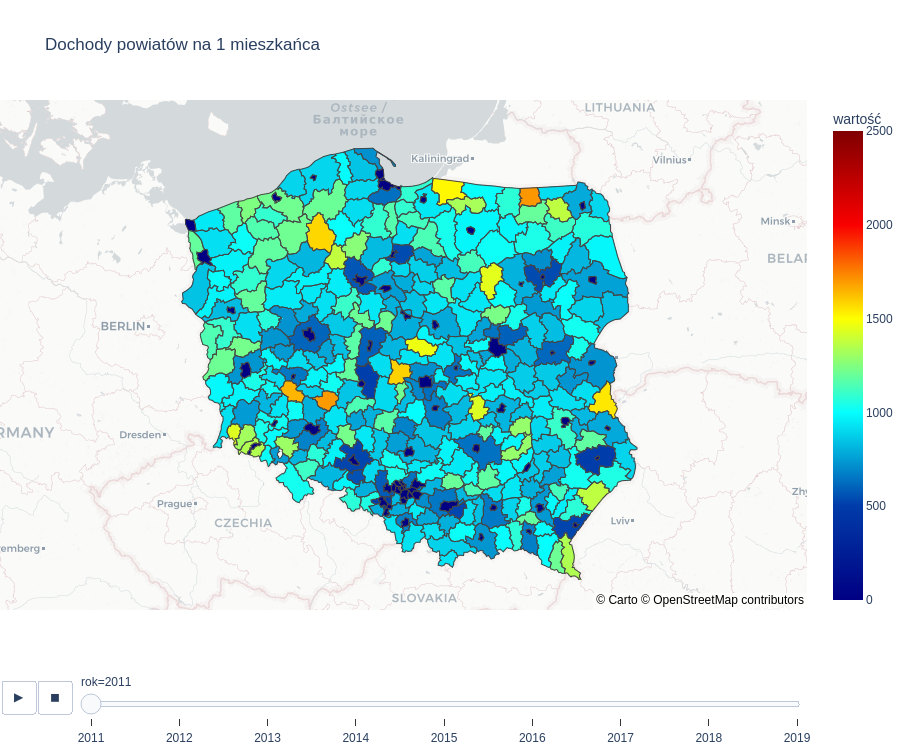

CPU times: user 4.27 s, sys: 32.1 ms, total: 4.3 s
Wall time: 8.45 s


In [19]:
%%time
fig = px.choropleth_mapbox(dochody_powiatow_pc, geojson=powiaty_fix, locations='powiat',
                           featureidkey="properties.JPT_NAZWA_", color='wartość',
                           animation_frame="rok", color_continuous_scale="jet",
                           range_color=[0,2500],
                           center={"lat": 52.1331, "lon": 19},
                           mapbox_style="carto-positron",
                           zoom=5,
                           opacity=1,
                           title="Dochody powiatów na 1 mieszkańca"
                          )
fig.update_layout(width=900,height=750,margin={"r":0,"t":100,"l":0,"b":0})
#fig.show()
fig.show("png")

## Other

In [20]:
finanse = pd.read_csv(path+'finanse_przedsiębiorstw_u.csv')

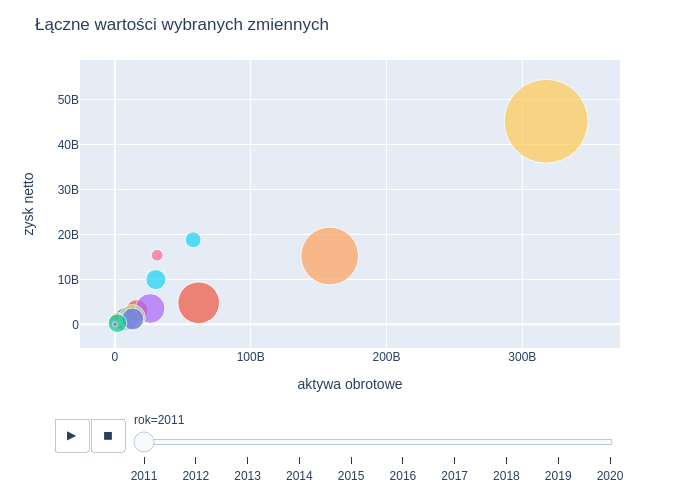

In [21]:
fig=px.scatter(finanse[finanse.rodzaj != 'Ogółem'],x="aktywa obrotowe",
               y='zysk netto',size='przedsiębiorstwa objęte badaniem',
               animation_frame="rok",color='rodzaj',
               size_max=60)
fig.update_layout(showlegend=False, title="Łączne wartości wybranych zmiennych")
#fig.show()
fig.show("png")

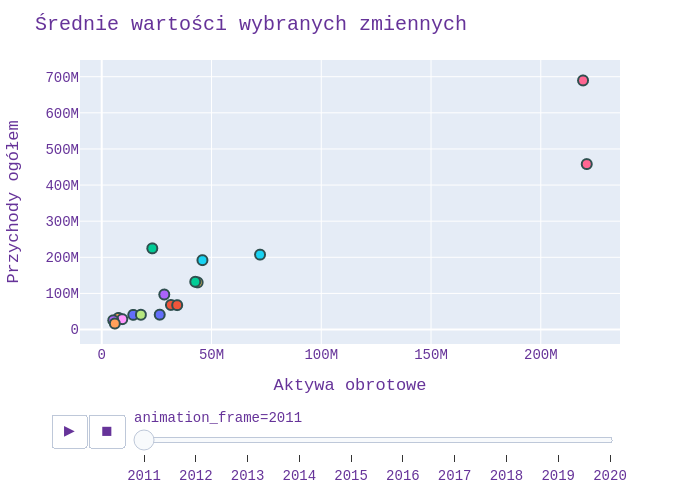

In [24]:
fig=px.scatter(x=finanse['aktywa obrotowe']/finanse['przedsiębiorstwa objęte badaniem'],
               y=finanse['przychody z całokształtu działalności (przychody ogółem)']/finanse['przedsiębiorstwa objęte badaniem'],
               animation_frame=finanse['rok'],color=finanse['rodzaj'])

fig.update_layout(
    title="Średnie wartości wybranych zmiennych",
    xaxis_title="Aktywa obrotowe",
    yaxis_title="Przychody ogółem",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="RebeccaPurple"
    ),
    showlegend=False
)
fig.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
#fig.show()
fig.show("png")

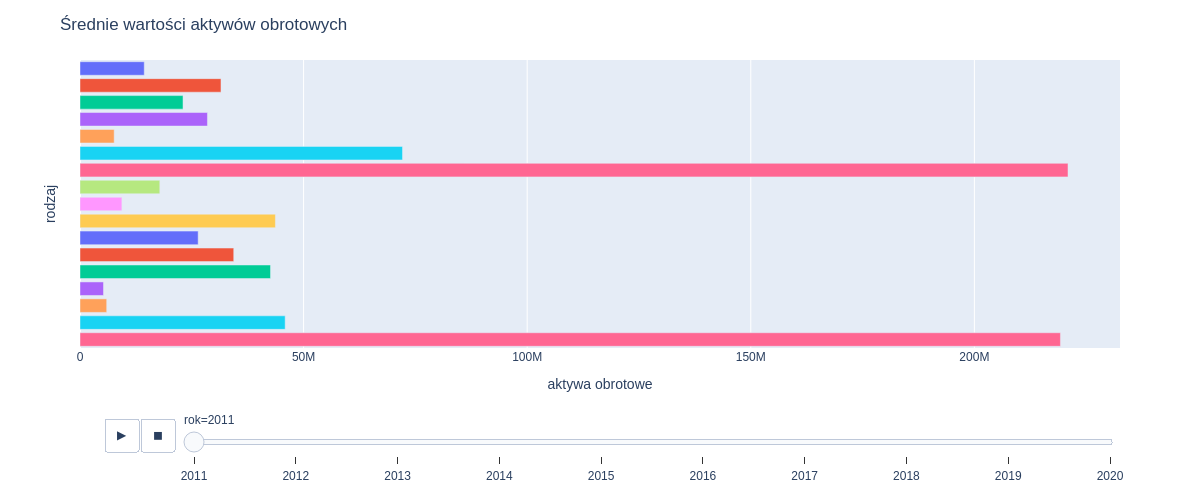

In [25]:
fig = px.bar(finanse, y="rodzaj", x=finanse['aktywa obrotowe']/finanse['przedsiębiorstwa objęte badaniem'], color="rodzaj", orientation='h',
  animation_frame="rok", animation_group="rok")
fig.update_layout(title="Średnie wartości aktywów obrotowych", showlegend=False,width=1200,xaxis_title="aktywa obrotowe")
fig.update_layout(yaxis={'visible': True, 'showticklabels': False})
#fig.show()
fig.show("png")